# Baseline models for ticket classification

This notebook trains simple baseline models for the customer support ticket classification task. The goals are:

1. Establish a very simple majority-class baseline.
2. Train a TF-IDF + Logistic Regression baseline.
3. Produce clear evaluation metrics and confusion matrices.



## Data loading and train/test split

Load the cleaned tickets dataset and split into features (text) and labels. We use stratified sampling to preserve class distribution between train and test sets and set a random seed for reproducibility.

In [1]:
# Standard imports used throughout the notebook
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load cleaned dataset (relative path)
df = pd.read_csv('../data/clean/clean_tickets.csv')
print(f'Shape of dataframe: {df.shape}')
df.head()

Shape of dataframe: (472, 4)


,text,label,ticket_id,agent_name
0,Where can I find API rate limits documentation?,other,1000,Dana
1,Can I migrate data from Freshdesk?,other,1001,Bob
2,Cannot update billing address; page keeps relo...,billing,1002,Charlie
3,Looking for a product roadmap or upcoming feat...,other,1003,Dana
4,Dark mode toggled but UI stays light.,technical,1004,Alice


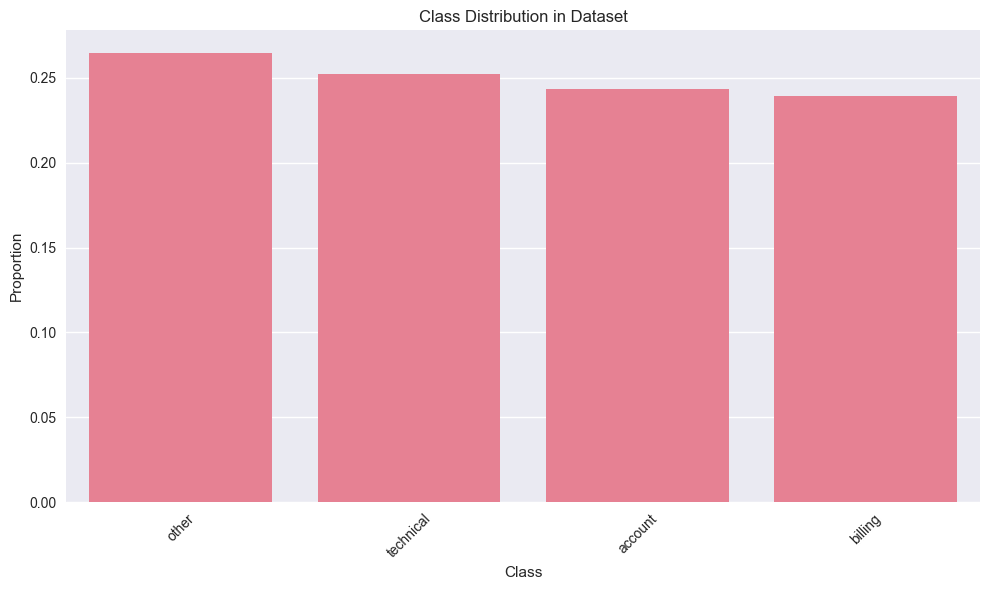

In [2]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
class_dist = df['label'].value_counts(normalize=True)
sns.barplot(x=class_dist.index, y=class_dist.values)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3]:
print('\nLabel distribution:')
for label, prop in class_dist.items():
    print(f'{label}: {prop:.3f}')

# Split into features and labels
X = df['text']
y = df['label']

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Second split: create validation set from remaining data
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 0.25 x 0.8 = 0.2 of original data
    stratify=y_temp,
    random_state=42
)

print('\nData split sizes:')
print(f'Training set: {len(X_train)} samples')
print(f'Validation set: {len(X_val)} samples')
print(f'Test set: {len(X_test)} samples')


Label distribution:
other: 0.265
technical: 0.252
account: 0.244
billing: 0.239

Data split sizes:
Training set: 282 samples
Validation set: 95 samples
Test set: 95 samples


## Majority-class baseline

We use scikit-learn's DummyClassifier with the 'most_frequent' strategy. This baseline always predicts the most common class from the training set and is useful to show the minimum performance to beat.

Baseline 5-fold CV scores: [0.10964912 0.10964912 0.11317907 0.11317907 0.11317907]
Average CV F1: 0.1118 (+/- 0.0035)

Majority baseline metrics (validation set):
  Accuracy: 0.2632
  Weighted F1: 0.1096

Classification report (majority baseline):
              precision    recall  f1-score   support

     account       0.00      0.00      0.00        23
     billing       0.00      0.00      0.00        23
       other       0.26      1.00      0.42        25
   technical       0.00      0.00      0.00        24

    accuracy                           0.26        95
   macro avg       0.07      0.25      0.10        95
weighted avg       0.07      0.26      0.11        95



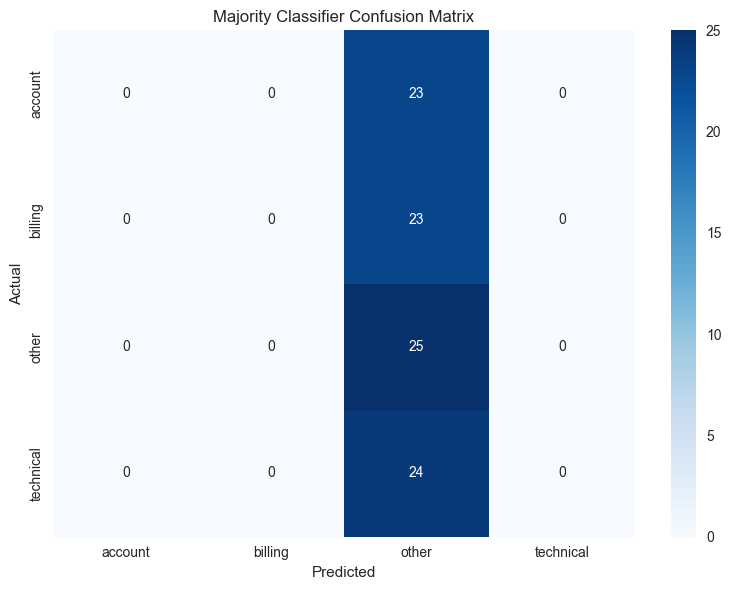

In [4]:
# Create pipeline for baseline model
baseline_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Default vectorizer for baseline
    ('classifier', DummyClassifier(strategy='most_frequent')),
])

# Fit and evaluate baseline
baseline_pipe.fit(X_train, y_train)

# Cross-validation scores for baseline
baseline_cv_scores = cross_val_score(
    baseline_pipe, X_train, y_train,
    cv=5, scoring='f1_weighted'
)

print("Baseline 5-fold CV scores:", baseline_cv_scores)
print(f"Average CV F1: {baseline_cv_scores.mean():.4f} (+/- {baseline_cv_scores.std() * 2:.4f})")

# Predict on validation set
y_pred_majority = baseline_pipe.predict(X_val)

# Compute evaluation metrics
acc_majority = accuracy_score(y_val, y_pred_majority)
f1_majority = f1_score(y_val, y_pred_majority, average='weighted')
cm_majority = confusion_matrix(y_val, y_pred_majority)

print('\nMajority baseline metrics (validation set):')
print(f'  Accuracy: {acc_majority:.4f}')
print(f'  Weighted F1: {f1_majority:.4f}')
print('\nClassification report (majority baseline):')
print(classification_report(y_val, y_pred_majority, zero_division=0))

# Save confusion matrix figure to artifacts for MLflow
import os
os.makedirs('../artifacts', exist_ok=True)
plt.figure(figsize=(8,6))
sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('Majority Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
majority_cm_path = '../artifacts/cm_majority.png'
plt.savefig(majority_cm_path)
plt.show()

Computing learning curves for Majority Classifier (this may take a moment)...


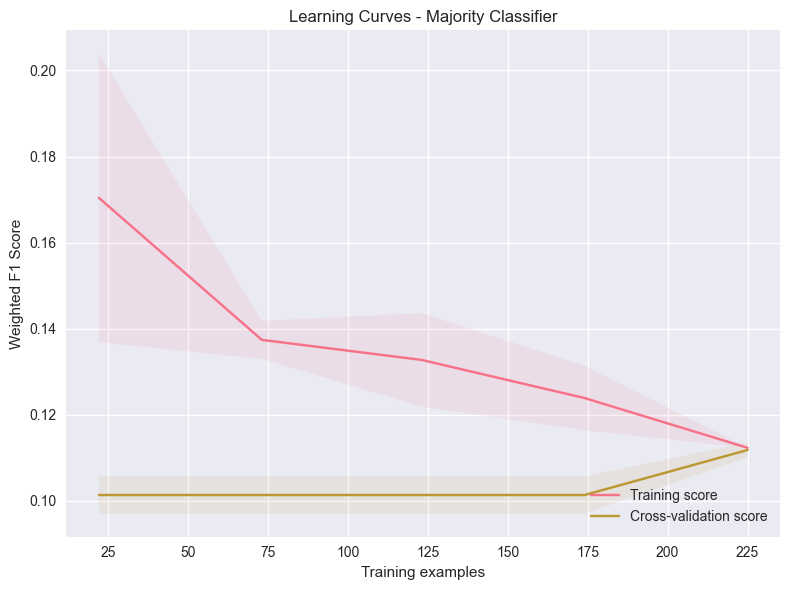

Saved majority learning curve to: ../artifacts/lc_majority.png


In [5]:
# Learning curve for Majority Classifier
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
import os

print("Computing learning curves for Majority Classifier (this may take a moment)...")
train_sizes, train_scores, val_scores = learning_curve(
    baseline_pipe, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, val_mean, label='Cross-validation score')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)

plt.xlabel('Training examples')
plt.ylabel('Weighted F1 Score')
plt.title('Learning Curves - Majority Classifier')
plt.legend(loc='lower right')
plt.grid(True)

# Save figure to artifacts
os.makedirs('../artifacts', exist_ok=True)
lc_path = '../artifacts/lc_majority.png'
plt.tight_layout()
plt.savefig(lc_path)
plt.show()
print(f"Saved majority learning curve to: {lc_path}")

In [6]:
# Create groups based on text similarity to ensure CV splits respect text clusters
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.sparse import hstack
from sklearn.model_selection import StratifiedGroupKFold

def create_text_groups(texts, n_char_features=100, n_word_features=100, random_state=42):
    """Create groups from text similarity using character and word n-grams."""
    # Preprocess
    processed_texts = texts.apply(lambda x: str(x).lower())
    
    # Create char and word n-gram features
    char_vec = HashingVectorizer(
        n_features=n_char_features,
        analyzer='char',
        ngram_range=(3, 5)
    )
    word_vec = HashingVectorizer(
        n_features=n_word_features,
        analyzer='word',
        ngram_range=(1, 2)
    )
    
    # Transform texts
    X_char = char_vec.transform(processed_texts)
    X_word = word_vec.transform(processed_texts)
    X_combined = hstack([X_char, X_word])
    
    # Cluster texts
    n_clusters = min(50, len(texts) // 10)  # Cap at 50 groups
    kmeans = MiniBatchKMeans(
        n_clusters=n_clusters,
        random_state=random_state
    )
    groups = kmeans.fit_predict(X_combined)
    return groups

# Create groups for CV
print("Creating text similarity groups for cross-validation...")
groups = create_text_groups(X_train)
print(f"Created {len(np.unique(groups))} groups from {len(X_train)} texts.")

# Initialize group-aware CV splitter
group_kfold = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

# Quick verification
n_unique_groups = len(np.unique(groups))
print(f"\nGroup statistics:")
print(f"Number of texts: {len(X_train)}")
print(f"Number of unique groups: {n_unique_groups}")
print(f"Average group size: {len(X_train) / n_unique_groups:.1f}")

Creating text similarity groups for cross-validation...
Created 28 groups from 282 texts.

Group statistics:
Number of texts: 282
Number of unique groups: 28
Average group size: 10.1


## Create Text Similarity Groups for Cross-Validation

Before we start modeling, we'll create groups based on text similarity. This ensures our cross-validation splits don't put similar texts in different folds, which would lead to overly optimistic scores.

Process:
1. Apply HashingVectorizer to create character and word n-gram features
2. Combine these features and cluster similar texts using MiniBatchKMeans
3. The resulting cluster assignments become our groups for StratifiedGroupKFold

These groups will be used consistently throughout all cross-validation operations in the notebook.

## TF-IDF vectorization

Convert raw text into numerical features using TF-IDF. We limit to the top 5,000 features for speed and to reduce noise. The vectorizer is fit on the training data only to avoid data leakage.

In [7]:
# Create pipeline for TF-IDF + LogReg
model_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        stop_words='english',
        min_df=2,
        max_df=0.95
    )),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__class_weight': [None, 'balanced'],
    'vectorizer__max_features': [3000, 5000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)]
}

# Perform cross-validated grid search on training data
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    model_pipe,
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

print(f'\nBest parameters found: {grid_search.best_params_}')
print(f'Best cross-validation score: {grid_search.best_score_:.4f}')

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found: {'classifier__C': 0.1, 'classifier__class_weight': None, 'vectorizer__max_features': 3000, 'vectorizer__ngram_range': (1, 2)}
Best cross-validation score: 0.9929


In [8]:
# Verify data split integrity
print("Checking for data leakage...")
print("\nSample overlap between splits:")
print(f"Train-Val overlap: {len(set(X_train.index) & set(X_val.index))}")
print(f"Train-Test overlap: {len(set(X_train.index) & set(X_test.index))}")
print(f"Val-Test overlap: {len(set(X_val.index) & set(X_test.index))}")

# Check feature independence
print("\nVerifying TF-IDF computation independence:")
# Create two separate vectorizers with same parameters
vec1 = TfidfVectorizer(max_features=5000)
vec2 = TfidfVectorizer(max_features=5000)

# Fit and transform on train vs test
X_train_vec1 = vec1.fit_transform(X_train)
X_test_vec2 = vec2.fit_transform(X_test)

# Compare vocabulary sizes
print(f"Train vocab size: {len(vec1.vocabulary_)}")
print(f"Test vocab size: {len(vec2.vocabulary_)}")
print(f"Vocabulary overlap: {len(set(vec1.vocabulary_.keys()) & set(vec2.vocabulary_.keys()))}")

# Print unique label counts in each split
print("\nLabel distribution in splits:")
print("\nTrain set:")
print(y_train.value_counts(normalize=True))
print("\nValidation set:")
print(y_val.value_counts(normalize=True))
print("\nTest set:")
print(y_test.value_counts(normalize=True))

Checking for data leakage...

Sample overlap between splits:
Train-Val overlap: 0
Train-Test overlap: 0
Val-Test overlap: 0

Verifying TF-IDF computation independence:
Train vocab size: 233
Test vocab size: 213
Vocabulary overlap: 209

Label distribution in splits:

Train set:
label
other        0.265957
technical    0.251773
account      0.244681
billing      0.237589
Name: proportion, dtype: float64

Validation set:
label
other        0.263158
technical    0.252632
billing      0.242105
account      0.242105
Name: proportion, dtype: float64

Test set:
label
other        0.263158
technical    0.252632
account      0.242105
billing      0.242105
Name: proportion, dtype: float64


In [9]:
# Enhanced TF-IDF + LogReg pipeline with feature selection and scaling
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MaxAbsScaler  # Safe for sparse matrices

# Create pipeline with feature selection and appropriate scaler
model_pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words='english',
        min_df=1,  # Start conservative, let grid search explore
        max_df=0.95
    )),
    ('scaler', MaxAbsScaler()),  # Scale features for chi2 and L1
    ('feature_select', SelectKBest(chi2)),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=2000,  # Increase for L1
        solver='saga'  # Supports both L1 and L2
    ))
])

# Enhanced parameter grid with:
# 1. Stronger regularization (smaller C values)
# 2. L1 and L2 penalties
# 3. Feature selection and dimensionality reduction
# 4. Class balancing
param_grid = {
    'vectorizer__max_features': [100, 200, 300],  # Reduced dimensionality
    'feature_select__k': [20, 50, 100],  # Further reduce features
    'classifier__C': [0.01, 0.05, 0.1, 0.5],  # Stronger regularization
    'classifier__penalty': ['l1', 'l2'],  # Try both L1 (sparse) and L2
    'classifier__class_weight': ['balanced']  # Handle class imbalance
}

# Defensive CV sizing: ensure number of folds does not exceed smallest class count
min_class_count = int(y_train.value_counts().min())
cv_splits = min(5, min_class_count) if min_class_count >= 2 else 2
if cv_splits < 2:
    print(f"Warning: very small class sizes; setting cv_splits=2 (min class count={min_class_count})")

# Initialize group-aware CV with stratification
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
group_kfold = StratifiedGroupKFold(n_splits=cv_splits, shuffle=True, random_state=42)

# Grid search with group-aware CV
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    model_pipe,
    param_grid,
    cv=group_kfold.split(X_train, y_train, groups=groups),
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Add frequency feature to training data
X_train_with_freq = pd.DataFrame({'text': X_train})
text_frequencies = X_train.value_counts()
X_train_with_freq['text_frequency'] = X_train_with_freq['text'].map(text_frequencies)

print("Starting grid search with group-aware CV...")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Analyze feature importance of best model
best_model = grid_search.best_estimator_
vectorizer = best_model.named_steps['vectorizer']
feature_selector = best_model.named_steps['feature_select']
classifier = best_model.named_steps['classifier']

if hasattr(vectorizer, 'get_feature_names_out'):
    feature_names = vectorizer.get_feature_names_out()
    selected_features_mask = feature_selector.get_support()
    selected_features = feature_names[selected_features_mask]
    
    if hasattr(classifier, 'coef_'):
        feature_importance = pd.DataFrame({
            'feature': selected_features,
            'importance': np.abs(classifier.coef_[0])
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 most important features:")
        print(feature_importance.head(10))

Starting grid search with group-aware CV...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best parameters found: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'feature_select__k': 100, 'vectorizer__max_features': 100}
Best cross-validation score: 0.2519

Top 10 most important features:
           feature  importance
3          account    0.067159
53            need    0.066878
99    verify phone    0.060705
98          verify    0.060705
67           phone    0.060705
57     number code    0.060705
17       code sent    0.060705
78      reset link    0.060382
77           reset    0.060382
66  password reset    0.060382


## TF-IDF + Logistic Regression baseline

Train a regularized Logistic Regression on TF-IDF features. We increase max_iter to ensure convergence on larger feature spaces. We report accuracy, weighted F1, and show a classification report for per-class metrics.

Generating learning curves (this may take a moment)...


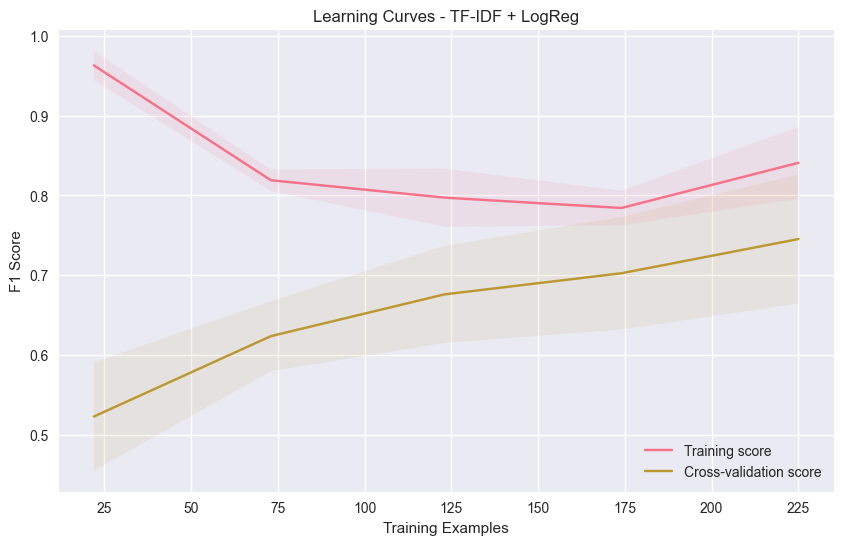


Validation Set Performance:
              precision    recall  f1-score   support

     account       0.76      0.83      0.79        23
     billing       0.85      0.74      0.79        23
       other       0.56      1.00      0.71        25
   technical       1.00      0.21      0.34        24

    accuracy                           0.69        95
   macro avg       0.79      0.69      0.66        95
weighted avg       0.79      0.69      0.66        95


Test Set Performance:
              precision    recall  f1-score   support

     account       0.65      0.87      0.74        23
     billing       0.86      0.78      0.82        23
       other       0.69      1.00      0.82        25
   technical       1.00      0.29      0.45        24

    accuracy                           0.74        95
   macro avg       0.80      0.74      0.71        95
weighted avg       0.80      0.74      0.71        95



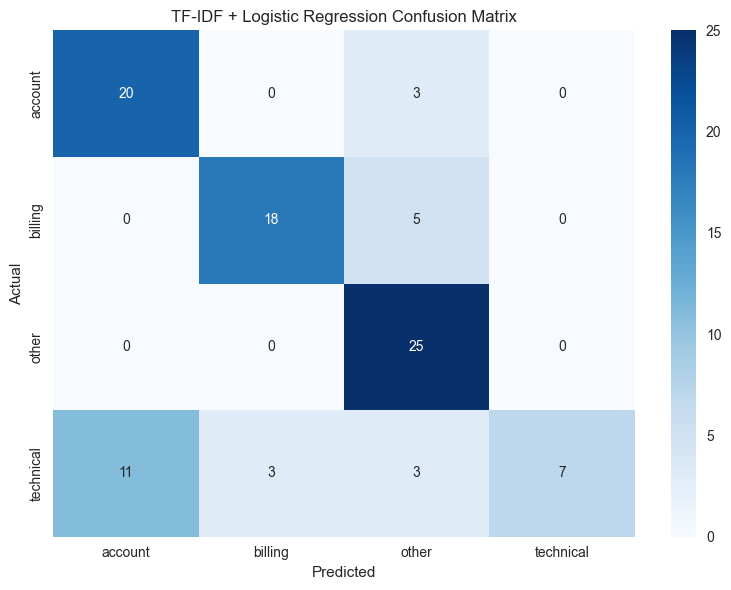


Model Performance Comparison:


,Metric,Validation,Test
0,Accuracy,0.6947,0.7368
1,Weighted F1,0.6582,0.7072


In [10]:
# Get best model
best_model = grid_search.best_estimator_

# Plot learning curves to check for overfitting
def plot_learning_curves(estimator, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=5, scoring='f1_weighted', n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.plot(train_sizes, val_mean, label='Cross-validation score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('F1 Score')
    plt.title(f'Learning Curves - {title}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

print("Generating learning curves (this may take a moment)...")
plot_learning_curves(best_model, 'TF-IDF + LogReg')

# Evaluate on validation set
y_pred_val = best_model.predict(X_val)
print('\nValidation Set Performance:')
print(classification_report(y_val, y_pred_val))

# Final evaluation on test set
y_pred_test = best_model.predict(X_test)
print('\nTest Set Performance:')
print(classification_report(y_test, y_pred_test))

# Store metrics for final comparison
acc_logreg = accuracy_score(y_test, y_pred_test)
f1_logreg = f1_score(y_test, y_pred_test, average='weighted')
cm_logreg = confusion_matrix(y_test, y_pred_test)

# Save confusion matrix for logreg
import os
os.makedirs('../artifacts', exist_ok=True)
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title('TF-IDF + Logistic Regression Confusion Matrix') 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
logreg_cm_path = '../artifacts/cm_logreg.png'
plt.savefig(logreg_cm_path)
plt.show()

# Compare validation and test performance
print('\nModel Performance Comparison:')
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted F1'],
    'Validation': [
        accuracy_score(y_val, y_pred_val),
        f1_score(y_val, y_pred_val, average='weighted')
    ],
    'Test': [
        accuracy_score(y_test, y_pred_test),
        f1_score(y_test, y_pred_test, average='weighted')
    ]
})
display(metrics_df.round(4))

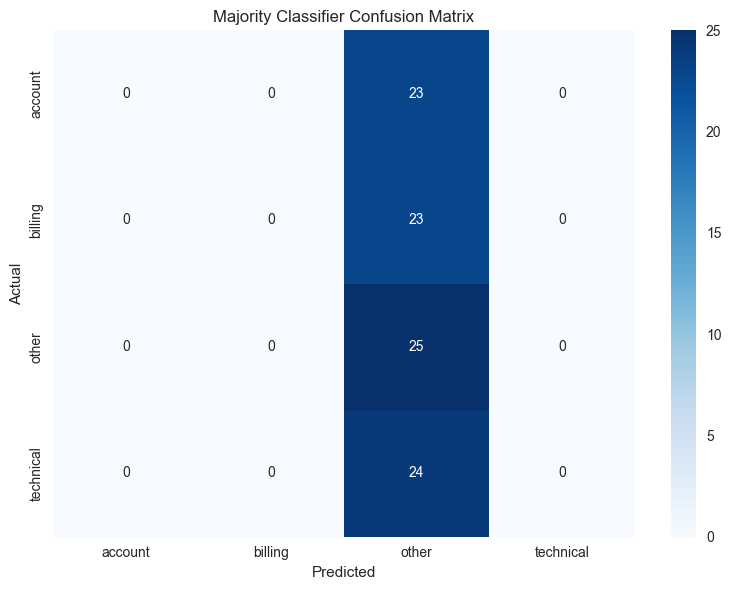

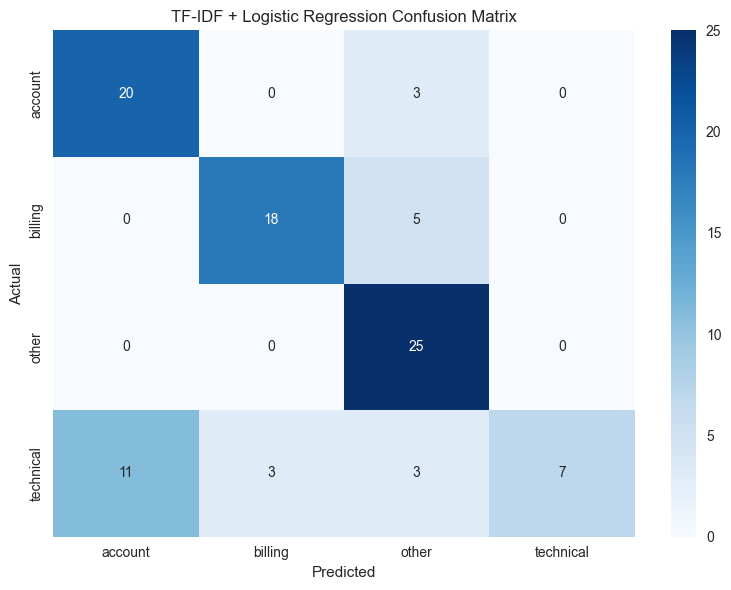


Summary of baseline results:


,model,accuracy,weighted_f1
0,majority,0.263158,0.109649
1,tfidf_logreg,0.736842,0.707218


In [11]:
def plot_confusion(cm, classes, title, figsize=(8,6)):
    """Plot a confusion matrix with class labels.
    Args:
        cm: confusion matrix (2D array)
        classes: list of class labels in the order used by the matrix
        title: plot title
    """
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Determine class order from the training labels to keep axes consistent
classes = sorted(y.unique())
plot_confusion(cm_majority, classes, 'Majority Classifier Confusion Matrix')
plot_confusion(cm_logreg, classes, 'TF-IDF + Logistic Regression Confusion Matrix')

# Save plots if not already saved
import os
os.makedirs('../artifacts', exist_ok=True)
if not os.path.exists('../artifacts/cm_majority.png'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Majority Classifier Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../artifacts/cm_majority.png')
    plt.close()

if not os.path.exists('../artifacts/cm_logreg.png'):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('TF-IDF + Logistic Regression Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../artifacts/cm_logreg.png')
    plt.close()

# Summary table comparing baselines
results = pd.DataFrame({
    'model': ['majority', 'tfidf_logreg'],
    'accuracy': [acc_majority, acc_logreg],
    'weighted_f1': [f1_majority, f1_logreg]
})
print('\nSummary of baseline results:')
display(results)

MLflow integration

In [13]:
# import mlflow
# import os

# mlflow.set_experiment("baseline_models")

# def safe_start_run(run_name, nested=False):
#     if mlflow.active_run() is not None:
#         mlflow.end_run()
#     return mlflow.start_run(run_name=run_name, nested=nested)

# # Start a parent run safely
# with safe_start_run("Baseline Model Experiments") as parent_run:

#     # Majority Classifier (nested run)
#     with safe_start_run("Majority Classifier", nested=True):
#         mlflow.log_param("model_type", "DummyClassifier")
#         mlflow.log_param("strategy", "most_frequent")
#         mlflow.log_metric("accuracy", acc_majority)
#         mlflow.log_metric("weighted_f1", f1_majority)
#         if os.path.exists(majority_cm_path):
#             mlflow.log_artifact(majority_cm_path)
#         else:
#             print(f"Warning: artifact not found: {majority_cm_path}")

#     # TF-IDF + Logistic Regression (nested run)
#     with safe_start_run("TFIDF + Logistic Regression", nested=True):
#         mlflow.log_param("model_type", "LogisticRegression")
#         mlflow.log_param("vectorizer", "TF-IDF")
#         mlflow.log_param("max_features", 5000)
#         mlflow.log_metric("accuracy", acc_logreg)
#         mlflow.log_metric("weighted_f1", f1_logreg)
#         if os.path.exists(logreg_cm_path):
#             mlflow.log_artifact(logreg_cm_path)
#         else:
#             print(f"Warning: artifact not found: {logreg_cm_path}")

import mlflow
import os
from pathlib import Path

# Ensure a valid local MLflow tracking URI (avoids malformed env var / network path issues)
_mlflow_dir = Path("./mlruns").resolve()
_mlflow_dir.mkdir(parents=True, exist_ok=True)
mlflow.set_tracking_uri(f"file://{_mlflow_dir.as_posix()}")

# Create artifacts folder if needed (used for saving confusion matrices etc.)
_artifacts_dir = Path("../artifacts").resolve()
_artifacts_dir.mkdir(parents=True, exist_ok=True)

# Safely set or create experiment
try:
    mlflow.set_experiment("baseline_models")
except Exception as e:
    # Fallback: create experiment manually if set_experiment fails for any reason
    print(f"Warning: mlflow.set_experiment failed: {e}. Attempting to create experiment directly.")
    client = mlflow.tracking.MlflowClient(tracking_uri=mlflow.get_tracking_uri())
    try:
        client.create_experiment("baseline_models", artifact_location=_mlflow_dir.as_posix())
    except Exception:
        # experiment may already exist; ignore
        pass
    mlflow.set_experiment("baseline_models")

def safe_start_run(run_name, nested=False):
    """Start a run, ending any active run first to avoid nested run state issues."""
    if mlflow.active_run() is not None:
        try:
            mlflow.end_run()
        except Exception:
            # best-effort end
            pass
    return mlflow.start_run(run_name=run_name, nested=nested)

# Start a parent run safely
with safe_start_run("Baseline Model Experiments") as parent_run:

    # Majority Classifier (nested run)
    with safe_start_run("Majority Classifier", nested=True):
        mlflow.log_param("model_type", "DummyClassifier")
        mlflow.log_param("strategy", "most_frequent")
        # Guard metric logging in case variables are missing
        if "acc_majority" in globals():
            mlflow.log_metric("accuracy", float(acc_majority))
        else:
            print("Warning: acc_majority not found; skipping metric log for majority.")
        if "f1_majority" in globals():
            mlflow.log_metric("weighted_f1", float(f1_majority))
        else:
            print("Warning: f1_majority not found; skipping metric log for majority.")
        # Log artifact if file exists
        if "majority_cm_path" in globals() and os.path.exists(majority_cm_path):
            mlflow.log_artifact(majority_cm_path)
        else:
            print(f"Warning: artifact not found or path undefined: {globals().get('majority_cm_path', '<undefined>')}")

    # TF-IDF + Logistic Regression (nested run)
    with safe_start_run("TFIDF + Logistic Regression", nested=True):
        mlflow.log_param("model_type", "LogisticRegression")
        mlflow.log_param("vectorizer", "TF-IDF")
        mlflow.log_param("max_features", 5000)
        if "acc_logreg" in globals():
            mlflow.log_metric("accuracy", float(acc_logreg))
        else:
            print("Warning: acc_logreg not found; skipping metric log for logreg.")
        if "f1_logreg" in globals():
            mlflow.log_metric("weighted_f1", float(f1_logreg))
        else:
            print("Warning: f1_logreg not found; skipping metric log for logreg.")
        if "logreg_cm_path" in globals() and os.path.exists(logreg_cm_path):
            mlflow.log_artifact(logreg_cm_path)
        else:
            print(f"Warning: artifact not found or path undefined: {globals().get('logreg_cm_path', '<undefined>')}")


In [14]:
import json

# Ensure artifacts directory exists
import os
os.makedirs('../artifacts', exist_ok=True)

metrics = {
    "majority_classifier": {
        "accuracy": float(acc_majority),
        "weighted_f1": float(f1_majority)
    },
    "tfidf_logistic_regression": {
        "accuracy": float(acc_logreg),
        "weighted_f1": float(f1_logreg)
    }
}

metrics_path = '../artifacts/baseline_metrics.json'
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

# Log metrics artifact to MLflow if available
if os.path.exists(metrics_path):
    mlflow.log_artifact(metrics_path)
else:
    print(f"Warning: could not find metrics file to log: {metrics_path}")

In [15]:
# Save the trained baseline model and metadata for comparison/deployment
import os
import json
import joblib

# Save model in artifacts directory
model_dir = "../artifacts/models/baseline"
os.makedirs(model_dir, exist_ok=True)

# Prefer `best_model` (GridSearch best estimator) then fall back to common pipeline names
model_to_save = None
for name in ("best_model", "baseline_pipe", "model_pipe", "baseline_cv_scores"):
    if name in globals():
        candidate = globals()[name]
        # only save sklearn Pipeline or estimator objects
        try:
            # quick duck-typing check
            if hasattr(candidate, "predict") or hasattr(candidate, "transform"):
                model_to_save = candidate
                break
        except Exception:
            pass

if model_to_save is None:
    raise NameError("No trained model pipeline found to save. Expected `best_model`, `baseline_pipe`, or `model_pipe`.")

pipe_path = os.path.join(model_dir, "baseline_pipeline.joblib")
joblib.dump(model_to_save, pipe_path)
print(f"Saved pipeline to: {pipe_path}")

# Save metadata (classes and metrics if available)
meta = {}
if "classes" in globals():
    meta["classes"] = list(classes)
if "metrics" in globals():
    # metrics may already be serializable, otherwise cast to str
    try:
        json.dumps(metrics)
        meta["metrics"] = metrics
    except Exception:
        meta["metrics"] = {k: str(v) for k, v in metrics.items()} if isinstance(metrics, dict) else str(metrics)

meta_path = os.path.join(model_dir, "metadata.json")
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)
print(f"Saved metadata to: {meta_path}")

# Quick verification: attempt to load
loaded = joblib.load(pipe_path)
print("Loaded saved pipeline. Example predict (on small sample) if X_test available:")
if "X_test" in globals():
    try:
        sample_X = X_test.iloc[:5] if hasattr(X_test, "iloc") else X_test[:5]
        preds = loaded.predict(sample_X)
        print("Prediction sample:", preds)
    except Exception as e:
        print("Could not run sample prediction:", e)
else:
    print("No X_test found in notebook globals to run a sample prediction.")

Saved pipeline to: ../artifacts/models/baseline\baseline_pipeline.joblib
Saved metadata to: ../artifacts/models/baseline\metadata.json
Loaded saved pipeline. Example predict (on small sample) if X_test available:
Prediction sample: ['account' 'account' 'other' 'other' 'other']
